In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

68616192/68606236 [==============================] - 6s 0us/step
Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


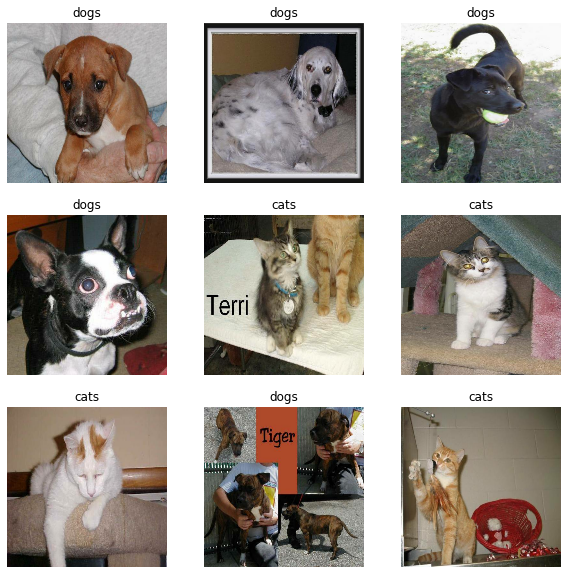

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


성능을 높이도록 데이터세트 구성하기
버퍼링된 프리페치를 사용하여 I/O 차단 없이 디스크에서 이미지를 로드합니다. 이 방법에 대해 자세히 알아보려면 데이터 성능 가이드를 참조하세요.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

데이터 증강 사용
큰 이미지 데이터세트가 없는 경우, 회전 및 수평 뒤집기와 같이 훈련 이미지에 무작위이지만 사실적인 변환을 적용하여 샘플 다양성을 인위적으로 도입하는 것이 좋습니다. 이것은 모델을 훈련 데이터의 다양한 측면에 노출시키고 과대적합을 줄이는 데 도움이 됩니다. 이 튜토리얼에서 데이터 증강에 대해 자세히 알아볼 수 있습니다.

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

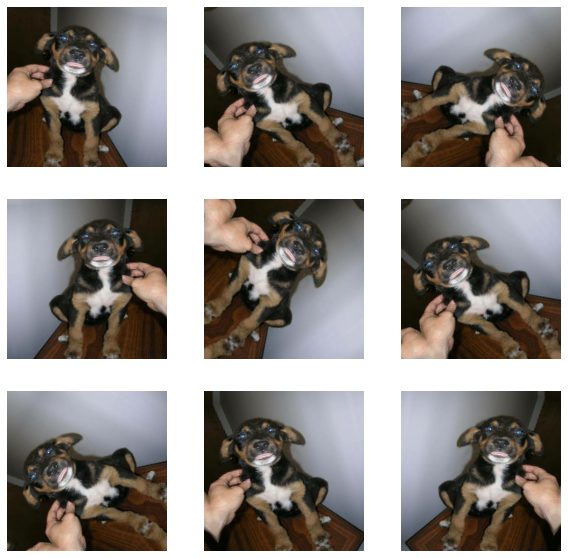

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

픽셀 값 재조정
잠시 후 기본 모델로 사용할 tf.keras.applications.MobileNetV2를 다운로드합니다. 이 모델은 [-1, 1]의 픽셀 값을 예상하지만 이 시점에서 이미지의 픽셀 값은 [0, 255]입니다. 크기를 재조정하려면 모델에 포함된 전처리 메서드를 사용하세요.

In [18]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

참고: 또는 크기 조정 레이어를 사용하여 [0, 255]에서 [-1, 1]로 픽셀 값을 재조정할 수 있습니다.

In [19]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

분류 층을 맨 위에 추가하기
특성 블록에서 예측을 생성하기 위해 tf.keras.layers.GlobalAveragePooling2D 레이어를 사용하여 특성을 이미지당 하나의 1280-요소 벡터로 변환하여 5x5 공간 위치에 대한 평균을 구합니다.

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


tf.keras.layers.Dense 레이어를 사용하여 특성을 이미지당 단일 예측으로 변환합니다. 이 예측은 logit또는 원시 예측 값으로 취급되므로 활성화 함수가 필요하지 않습니다. 양수는 클래스 1을 예측하고 음수는 클래스 0을 예측합니다.

In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

모델 컴파일
학습하기 전에 모델을 컴파일해야 합니다. 두 개의 클래스가 있으므로 모델이 선형 출력을 제공하므로 from_logits = True와 함께 이진 교차 엔트로피 손실을 사용하세요.

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [23]:
len(model.trainable_variables)

2

In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 3s 30ms/step - loss: 0.8176 - accuracy: 0.4814


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.82
initial accuracy: 0.48


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 5s 37ms/step - loss: 0.6769 - accuracy: 0.5910 - val_loss: 0.5060 - val_accuracy: 0.6943
Epoch 2/10
63/63 [==============================] - 2s 34ms/step - loss: 0.4831 - accuracy: 0.7380 - val_loss: 0.3655 - val_accuracy: 0.8292
Epoch 3/10
63/63 [==============================] - 2s 33ms/step - loss: 0.3745 - accuracy: 0.8190 - val_loss: 0.2652 - val_accuracy: 0.9047
Epoch 4/10
63/63 [==============================] - 2s 33ms/step - loss: 0.3118 - accuracy: 0.8555 - val_loss: 0.2109 - val_accuracy: 0.9307
Epoch 5/10
63/63 [==============================] - 2s 33ms/step - loss: 0.2781 - accuracy: 0.8735 - val_loss: 0.1743 - val_accuracy: 0.9394
Epoch 6/10
63/63 [==============================] - 2s 34ms/step - loss: 0.2531 - accuracy: 0.8935 - val_loss: 0.1517 - val_accuracy: 0.9418
Epoch 7/10
63/63 [==============================] - 2s 33ms/step - loss: 0.2185 - accuracy: 0.9060 - val_loss: 0.1307 - val_accuracy: 0.9579
Epoch 8/10
63

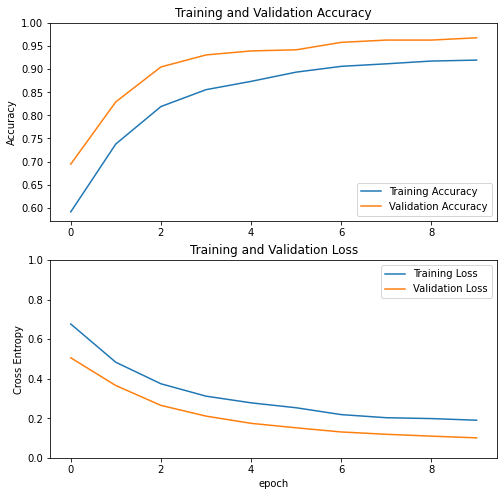

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [32]:
len(model.trainable_variables)

56

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 9s 62ms/step - loss: 0.1630 - accuracy: 0.9325 - val_loss: 0.0496 - val_accuracy: 0.9827
Epoch 11/20
63/63 [==============================] - 3s 50ms/step - loss: 0.1087 - accuracy: 0.9545 - val_loss: 0.1009 - val_accuracy: 0.9653
Epoch 12/20
63/63 [==============================] - 3s 50ms/step - loss: 0.1006 - accuracy: 0.9575 - val_loss: 0.0428 - val_accuracy: 0.9889
Epoch 13/20
63/63 [==============================] - 3s 50ms/step - loss: 0.0924 - accuracy: 0.9585 - val_loss: 0.0524 - val_accuracy: 0.9752
Epoch 14/20
63/63 [==============================] - 3s 50ms/step - loss: 0.0824 - accuracy: 0.9680 - val_loss: 0.0326 - val_accuracy: 0.9839
Epoch 15/20
63/63 [==============================] - 3s 49ms/step - loss: 0.0778 - accuracy: 0.9720 - val_loss: 0.0363 - val_accuracy: 0.9864
Epoch 16/20
63/63 [==============================] - 3s 49ms/step - loss: 0.0858 - accuracy: 0.9625 - val_loss: 0.0405 - val_accuracy: 0.9889
Epoch 

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

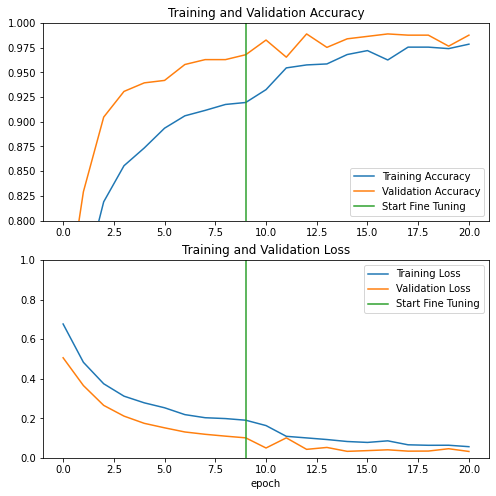

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 22ms/step - loss: 0.0332 - accuracy: 0.9844
Test accuracy : 0.984375


Predictions:
 [1 1 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0]
Labels:
 [1 1 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0]


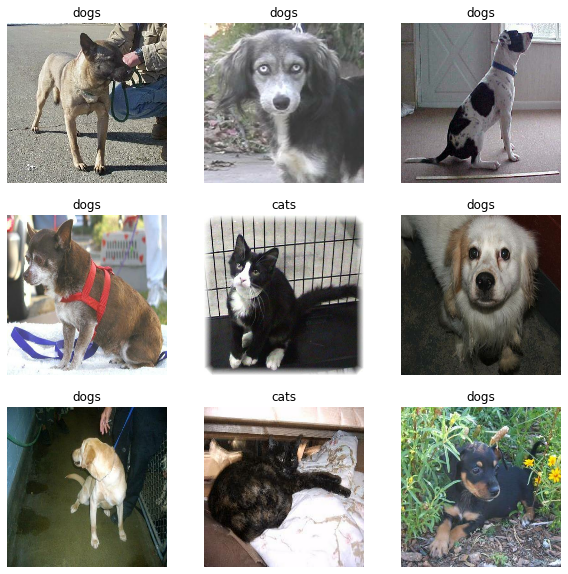

In [37]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")